##**Система рекомендации курсов на основе тегов и сложности курсов (stepik)**
###Моисеенко Дмитрий J41111

Получение готовых данных о курсах с гугл диска, парсинг данных можно пропустить.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp "drive/My Drive/data.csv" data.csv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

df = pd.read_csv('data.csv', index_col=0)

### Парсинг данных

In [ ]:
import requests
import json
import re

# Шаблон ссылшки на курс
course_url = 'https://stepik.org/course/{}/info' 
# Паттерн регулярки для извлечения информации о курсе со страницы
pattern = r"__stepik_shoebox__ = JSON.parse\(\'(.*)\'\);"

In [ ]:
def get_course_info(url):
  '''
  Получение информации о курсе по ссылке
  '''
  r = requests.get(url)
  
  if not r.ok:
    print(end='N')
    return

  match = re.search(pattern, r.text)
  try:
    cource_json = json.loads(match.groups(1)[0].encode().decode('unicode_escape'))
    data = {
      'id': cource_json['courses'][0]['id'],
      'title': cource_json['courses'][0]['title'],
      'description': cource_json['courses'][0]['description'],
      'summary': cource_json['courses'][0]['summary'],
      'average': cource_json['course-review-summaries'][0]['average'],
      'count': cource_json['course-review-summaries'][0]['count'],
      '1_star': cource_json['course-review-summaries'][0]['distribution'][0],
      '2_star': cource_json['course-review-summaries'][0]['distribution'][1],
      '3_star': cource_json['course-review-summaries'][0]['distribution'][2],
      '4_star': cource_json['course-review-summaries'][0]['distribution'][3],
      '5_star': cource_json['course-review-summaries'][0]['distribution'][4],
    }

    print(end='O')
    return data
  except Exception as e:
    print(end='X')
    return

Пример получаемых данных

In [ ]:
get_course_info(course_url.format(94))

O

{'1_star': 0,
 '2_star': 0,
 '3_star': 1,
 '4_star': 14,
 '5_star': 108,
 'average': 4.86991869918699,
 'count': 123,
 'description': 'Курс познакомит слушателей с основными методами генной инженерии, применяемыми в лабораторной практике. В течение четырех недель мы рассмотрим базовые подходы к получению рекомбинантных ДНК, полимеразную цепную реакцию, ее модификации и их применение. Мы затронем понятие молекулярного клонирования и проведем краткий обзор технологий высокопроизводительного клонирования. В последних модулях мы поговорим о подходах к синтезу генов и целых геномов с нуля и о том, как генная инженерия применяется к задаче синтеза белков в различных организмах.\n<br><br>\nЕсли вы хотите освежить свои знания молекулярной биологии, рекомендуем пройти открытый курс <a href="https://stepic.org/course/Молекулярная-биология-и-генетика-70/" rel="nofollow noopener noreferrer">«Молекулярная биология и генетика»</a>.',
 'id': 94,
 'summary': 'Курс рассчитан на широкую аудиторию и осве

In [ ]:
data = []

Начинаем собирать данные (если процесс прервался, его можно перезапустить, и он продолжится с последнего сохраненного курса)

In [ ]:
from tqdm.notebook import tqdm

start = data[-1]['id'] + 1 if data else 1
end = 110001

for i in tqdm(range(start, end),
              initial=start-1,
              total=end-1,
              desc='Parsing courses'):
  course_info = get_course_info(course_url.format(i))

  if course_info:
    data.append(course_info)

Parsing courses:   9%|9         | 10305/110000 [00:00<?, ?it/s]

NXNNNNNNNNNNNNNNNNNNNNXNNNNNNXNNNNNNNNNNNNNXXXNNNNNNNNNNNNNNXNNNXXNNNNXNNNXNNNNNNNXXNNNNNNNNNNNNNNONNNNNNNNNNNNNNNOXOXOOXXXNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNXNXNXXXXNNNNNNNNNNOXXONXOOONONNNNNONONNNXNXXONNNNNNNNNNNNNNNOOOXNNXXXNNNNNNNNNNNNNNNXXXXXXXXOXXNOXXOONOOXOXOOXXOOOXXOOXXOXXNNNNNNNNNNNNNNNNNNNNNXNXNNXNXXNNNNNNNNNNNNNNNXXO

KeyboardInterrupt: ignored

Преобразование в DataFrame

In [ ]:
import pandas as pd

df = pd.DataFrame(data, columns=['id','title','summary','average','count','description','1_star','2_star','3_star','4_star','5_star'])

Сохранение на гугл диск

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df.to_csv('data.csv')
!cp data.csv "drive/My Drive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Предобработка

In [ ]:
df

,id,title,summary,average,count,description,1_star,2_star,3_star,4_star,5_star
0,1,Epic Guide to Stepik,"<p>This is a collection on lessons, describing...",4.750000,4,<p>This course is about Stepik.</p><p><a href=...,0,0,0,1,3
1,5,Python for Beginners,NaN,4.238095,21,NaN,1,2,0,6,12
2,7,Программирование на языке C++,Данный базовый курс повествует об основных сре...,4.649123,684,<p> Программа курса основана на программах кур...,14,12,26,96,536
3,10,Python for Programmers,Based on the presentation by Alex Martelli.,2.714286,7,"Based on <a href=""http://www.aleax.it/goo_py4p...",1,3,1,1,1
4,43,City Design,City Design online course shows the fundamenta...,3.500000,12,<p>Course goals:</p><p>1. Inspire learners and...,3,0,2,2,5
...,...,...,...,...,...,...,...,...,...,...,...
9642,88991,The most popular cloud services,NaN,0.000000,0,"<p>In this course, you will learn the types of...",0,0,0,0,0
9643,88992,Pastry skills courses,Everyone can learn how to make cakes for sale ...,0.000000,0,<p><strong><em>A good pastry chef is always in...,0,0,0,0,0
9644,88994,English course,NaN,0.000000,0,NaN,0,0,0,0,0
9645,88998,Java Course elso,"Java course.\nCreated: Dec 4, 2020, 8:21:17 AM.",0.000000,0,NaN,0,0,0,0,0


Описание имеющихся данных:
- id - Номер курса на stepik
- title - Название курса
- summary - Короткое описание
- average - Средняя оценка курса
- count - Число оценок
- description - Длинное описание
- *_star - Распределение оценок за курс

Посмотрим на число отсутствующих данных

In [ ]:
df.isna().sum()

id                0
title             0
summary        2017
average           0
count             0
description    4400
1_star            0
2_star            0
3_star            0
4_star            0
5_star            0
dtype: int64

Видим, что отсутствуют только короткие и длинные описания (хотя есть ещё не отсутствующие, но пустые), заменим их пустой строкой

In [ ]:
df['summary'] = df['summary'].fillna('')
df['description'] = df['description'].fillna('')

In [ ]:
df.isna().sum()

id             0
title          0
summary        0
average        0
count          0
description    0
1_star         0
2_star         0
3_star         0
4_star         0
5_star         0
dtype: int64

Замечательно

Посмотрим, сколько данных в каждой колонке не пусты (сколько курсов имеет хоть какую-нибудь оценку или какое-либо описание)

In [ ]:
# Сколько курсов имеет отзывы
len(df[df['count'] > 0])

2000

In [ ]:
# Сколько курсов имеет короткое описание
len(df[df['summary'] != ''])

7630

In [ ]:
# Сколько курсов имеет длинное описание
len(df[df['description'] != ''])

5247

Скорее всего, не стоит рекомендовать пользователю курсы совсем без отзывов, а если в нем не присутствует хоть какое-нибудь описание, то сложно будет понять, о чем этот курс и его релевантность, поэтому выделим такие курсы в новый DataFrame

In [ ]:
df1 = df[(df['count'] > 0) & ((df['summary'] != '') | (df['description'] != ''))]
df1

,id,title,summary,average,count,description,1_star,2_star,3_star,4_star,5_star
0,1,Epic Guide to Stepik,"<p>This is a collection on lessons, describing...",4.750000,4,<p>This course is about Stepik.</p><p><a href=...,0,0,0,1,3
2,7,Программирование на языке C++,Данный базовый курс повествует об основных сре...,4.649123,684,<p> Программа курса основана на программах кур...,14,12,26,96,536
3,10,Python for Programmers,Based on the presentation by Alex Martelli.,2.714286,7,"Based on <a href=""http://www.aleax.it/goo_py4p...",1,3,1,1,1
4,43,City Design,City Design online course shows the fundamenta...,3.500000,12,<p>Course goals:</p><p>1. Inspire learners and...,3,0,2,2,5
6,51,Археология фольклора: мифологические мотивы на...,Исследование мирового фольклора позволяет увид...,4.750000,120,<p>В мире записаны многие десятки тысяч фолькл...,0,2,3,18,97
...,...,...,...,...,...,...,...,...,...,...,...
9537,88632,Информатика 1 курс,Общеобразовательный курс для студентов 1 курса...,5.000000,2,<p>Общеобразовательный курс для студентов 1 ку...,0,0,0,0,2
9540,88653,Python Programming for NIS,Сборник задач для развития навыков программиро...,5.000000,2,"<p>Сборник задач для реализации программы ""Про...",0,0,0,0,2
9550,88692,Макияж для себя,,5.000000,1,<p>Двадцать лет назад нанесение повседневного ...,0,0,0,0,1
9554,88698,История искусств: итальянская живопись эпохи В...,"Первая часть цикла видео-лекций, посвященная и...",5.000000,2,<p>Эпоха Возрождения положила начало новому эт...,0,0,0,0,2


Среди описаний присутствуют html-теги, их стоит убрать

In [ ]:
import re

df1.summary = df1.summary.str.replace('<[^<]+?>', ' ')
df1.description = df1.description.str.replace('<[^<]+?>', ' ')
df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


,id,title,summary,average,count,description,1_star,2_star,3_star,4_star,5_star
0,1,Epic Guide to Stepik,"This is a collection on lessons, describing wh...",4.750000,4,This course is about Stepik.Stepik is a cloud-...,0,0,0,1,3
2,7,Программирование на языке C++,Данный базовый курс повествует об основных сре...,4.649123,684,Программа курса основана на программах курсов...,14,12,26,96,536
3,10,Python for Programmers,Based on the presentation by Alex Martelli.,2.714286,7,Based on the presentation by Alex Martelli.\nC...,1,3,1,1,1
4,43,City Design,City Design online course shows the fundamenta...,3.500000,12,Course goals:1. Inspire learners and help them...,3,0,2,2,5
6,51,Археология фольклора: мифологические мотивы на...,Исследование мирового фольклора позволяет увид...,4.750000,120,В мире записаны многие десятки тысяч фольклорн...,0,2,3,18,97
...,...,...,...,...,...,...,...,...,...,...,...
9537,88632,Информатика 1 курс,Общеобразовательный курс для студентов 1 курса...,5.000000,2,Общеобразовательный курс для студентов 1 курса...,0,0,0,0,2
9540,88653,Python Programming for NIS,Сборник задач для развития навыков программиро...,5.000000,2,"Сборник задач для реализации программы ""Програ...",0,0,0,0,2
9550,88692,Макияж для себя,,5.000000,1,Двадцать лет назад нанесение повседневного мак...,0,0,0,0,1
9554,88698,История искусств: итальянская живопись эпохи В...,"Первая часть цикла видео-лекций, посвященная и...",5.000000,2,Эпоха Возрождения положила начало новому этапу...,0,0,0,0,2


Теперь подготовим текстовую информацию к использованию, создадим новый столбец, в котором объединим название, короткое и длинные описания в одну строку

In [ ]:
df1['text'] = df1.apply(lambda row: row.title + ' ' + row.summary + ' ' + row.description, axis=1)
df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,title,summary,average,count,description,1_star,2_star,3_star,4_star,5_star,text
0,1,Epic Guide to Stepik,"This is a collection on lessons, describing wh...",4.750000,4,This course is about Stepik.Stepik is a cloud-...,0,0,0,1,3,Epic Guide to Stepik This is a collection on l...
2,7,Программирование на языке C++,Данный базовый курс повествует об основных сре...,4.649123,684,Программа курса основана на программах курсов...,14,12,26,96,536,Программирование на языке C++ Данный базовый к...
3,10,Python for Programmers,Based on the presentation by Alex Martelli.,2.714286,7,Based on the presentation by Alex Martelli.\nC...,1,3,1,1,1,Python for Programmers Based on the presentati...
4,43,City Design,City Design online course shows the fundamenta...,3.500000,12,Course goals:1. Inspire learners and help them...,3,0,2,2,5,City Design City Design online course shows th...
6,51,Археология фольклора: мифологические мотивы на...,Исследование мирового фольклора позволяет увид...,4.750000,120,В мире записаны многие десятки тысяч фольклорн...,0,2,3,18,97,Археология фольклора: мифологические мотивы на...
...,...,...,...,...,...,...,...,...,...,...,...,...
9537,88632,Информатика 1 курс,Общеобразовательный курс для студентов 1 курса...,5.000000,2,Общеобразовательный курс для студентов 1 курса...,0,0,0,0,2,Информатика 1 курс Общеобразовательный курс д...
9540,88653,Python Programming for NIS,Сборник задач для развития навыков программиро...,5.000000,2,"Сборник задач для реализации программы ""Програ...",0,0,0,0,2,Python Programming for NIS Сборник задач для р...
9550,88692,Макияж для себя,,5.000000,1,Двадцать лет назад нанесение повседневного мак...,0,0,0,0,1,Макияж для себя Двадцать лет назад нанесение ...
9554,88698,История искусств: итальянская живопись эпохи В...,"Первая часть цикла видео-лекций, посвященная и...",5.000000,2,Эпоха Возрождения положила начало новому этапу...,0,0,0,0,2,История искусств: итальянская живопись эпохи В...


Так как присутствуют и английские и русские курсы, будем обрабатывать их вместе, удаляя и английские и русские stopwords

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + stopwords.words('russian') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [ ]:
df1['text'] = df1.apply(lambda row: preprocess(row.text), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df1['text']

0       epic guide stepik collection lesson describing...
2       программирование языке данный базовый курс пов...
3       python programmer based presentation alex mart...
4       city design city design online course show fun...
6       археология фольклора мифологические мотивы кар...
                              ...                        
9537    информатика курс общеобразовательный курс студ...
9540    python programming ni сборник задач развития н...
9550    макияж двадцать лет назад нанесение повседневн...
9554    история искусств итальянская живопись эпохи во...
9561    физика школьный курс класс обращайте внимание ...
Name: text, Length: 1939, dtype: object

Визуализируем частоту слов

In [ ]:
from wordcloud import WordCloud

def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

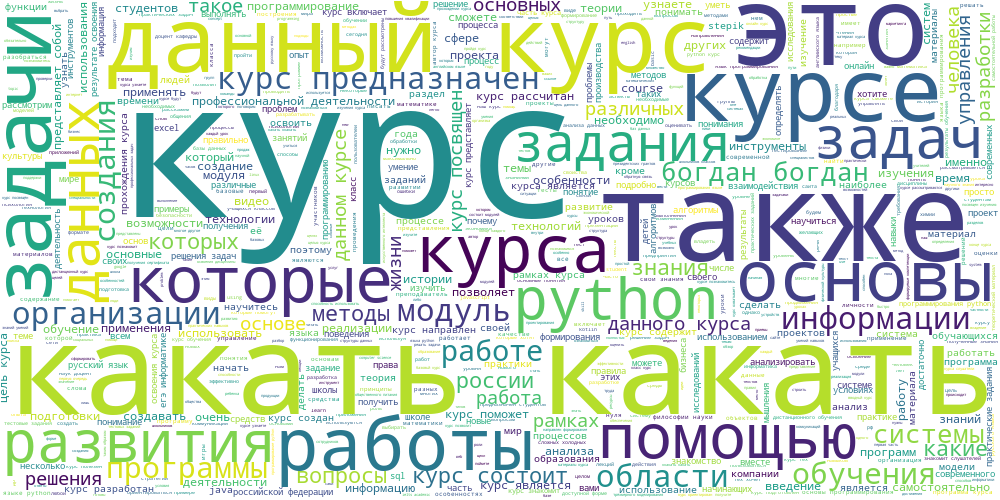

In [ ]:
draw_wordcloud(df1.text)

###Система рекомендаций

Переведем текст в пространство TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df1['text'])

Пользовательский ввод будет переведен в это же пространство, после чего наиболее близкие векторы будут соответствовать нужным

In [ ]:
import numpy as np
X_arr = X.toarray()

def get_recommendations(raw_query, count=10):
  query = preprocess(raw_query)
  X_query = vectorizer.transform([query]).toarray()[0] > 0
  relevants = np.apply_along_axis(lambda row: row[X_query].sum(), 1, X_arr)
  relevants = np.argsort(relevants)[::-1][:count]

  df1.reset_index(drop = True, inplace = True)
  relevant_rows = df1.iloc[relevants]
  return relevant_rows

In [ ]:
user_input = 'python машинное обучение'

In [ ]:
get_recommendations(user_input)

,id,title,summary,average,count,description,1_star,2_star,3_star,4_star,5_star,text
1768,83990,Обработка данных в Python Pandas,Курс предназначен школьникам 8-11 классов и ст...,3.642857,28,Курс предназначен школьникам 8-11 классов и ст...,1,3,8,9,7,обработка данных python panda курс предназначе...
1163,63223,Программирование на Python. Начало.,В данном курсе рассматриваются основные алгори...,4.588235,17,Сейчас Python является вторым по популярности ...,0,0,1,5,11,программирование python начало данном курсе ра...
971,58137,Copy of Python,Практические задания по основам программирован...,3.666667,3,Практические задания по основам программирован...,0,0,2,0,1,copy python практические задания основам прогр...
500,21421,Introduction to Python,Introduction course to Python.,4.400000,5,,0,0,0,3,2,introduction python introduction course python
299,4291,Программирование на Python 7-9 классы,Курс программирования на языке Python для школ...,4.500000,2,Курс программирования на языке Python для школ...,0,0,0,1,1,программирование python классы курс программир...
415,8300,Олимпиадные задачи,Тренировки по решению олимпиадных задач на язы...,2.500000,2,Тренировки по решению олимпиадных задач на язы...,1,0,0,1,0,олимпиадные задачи тренировки решению олимпиад...
337,4852,Введение в Data Science и машинное обучение,Курс знакомит слушателей с основами машинного ...,4.926489,789,Data Scientist is The Sexiest Job of the 21st ...,2,2,1,42,742,введение data science машинное обучение курс з...
220,2740,Introduction to Python,The Introduction to Python challenges are used...,4.000000,25,This is an introduction to python with 15 chal...,4,0,2,5,14,introduction python introduction python challe...
1828,85388,"Python для тех, у кого лапки",Хотите освоить Python без опыта программирован...,5.000000,10,"Python для тех, у кого лапки\n\nЕсли вы хотите...",0,0,0,0,10,python тех кого лапки хотите освоить python оп...
963,57948,Программирование на Python [Sanak-lab],Курс по основам программирования на Python для...,3.956522,23,"Курс ""Основы программирования на Python""\n\nЦе...",0,2,6,6,9,программирование python курс основам программи...


К сожалению не успел доделать из-за большой загруженности. Планировал ещё учитывать среднюю оценку нормированную по количеству пользователей (чем их меньше проголосовало, тем меньше правдива условная оценка 5 для курса), а так же из предположения, что чем больше плохих оценок, тем сложнее курс(при нормальной средней), сделать такие курсы чуть более релевантными.